In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
import numpy as np

In [3]:
def get_ticker_data(ticker_string):
    #FOR 5YRS ENDING 2018:
    temp_df = yf.download(ticker_string, start='2013-12-31', end='2018-12-31', interval='1d')
    # FOR LATEST 5YRS:
    # temp_df = yf.download(ticker_string, period='5y', interval='1d')
    temp_df['Volume'] = temp_df['Volume'].div(1000000)  # Scale Volume Column down
    price_data = temp_df['Close']         # Remove unneeded data
    vol_data = temp_df['Volume']
    return price_data, vol_data


def set_rand_port_weights(num_ports=20000, num_assets=None):
    np.random.seed(123)
    temp_p_weights = np.random.random(num_assets * num_ports).reshape(num_ports, num_assets)
    # Divide by sum of rows so each row sums to 1
    scaled_port_weights = temp_p_weights / temp_p_weights.sum(axis=1, keepdims=True)
    return scaled_port_weights


def annual_risk_return(daily_returns):
    stats = daily_returns.agg(['mean', 'std']).T
    stats.columns = ['Return', 'Risk']
    stats.Return = stats.Return * 252  # 252 Business days per year
    stats.Risk = stats.Risk * np.sqrt(252)  # As Risk is sqrt of variance
    return stats

# Get User to Input Ticker Symbols and Count the Number Given
asset_input = input('Select company ticker symbols: ')
ticker_symbols = asset_input.split(' ')
num_assets_given = len(ticker_symbols)

# Import Data and Initialise Random Weights
price_data, vol_data = get_ticker_data(asset_input)
rand_port_weights = set_rand_port_weights(num_assets=num_assets_given)

[*********************100%***********************]  7 of 7 completed


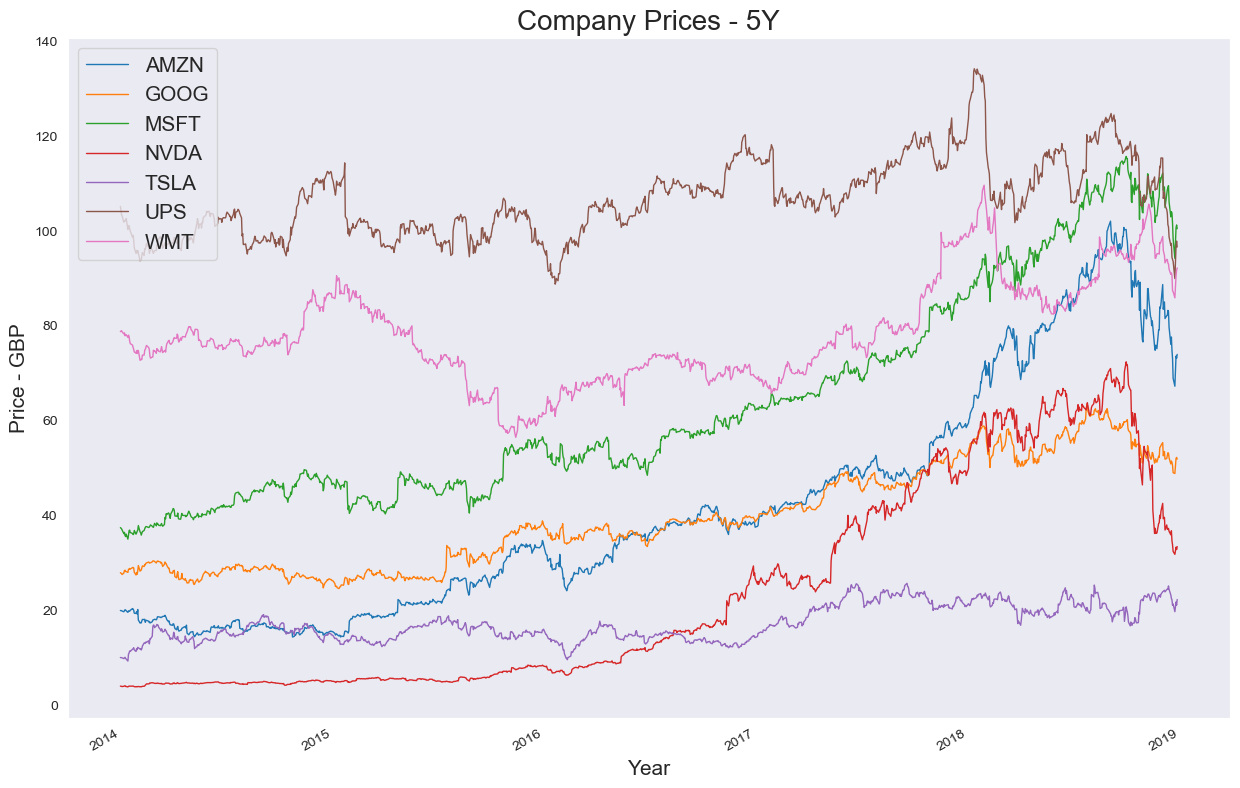

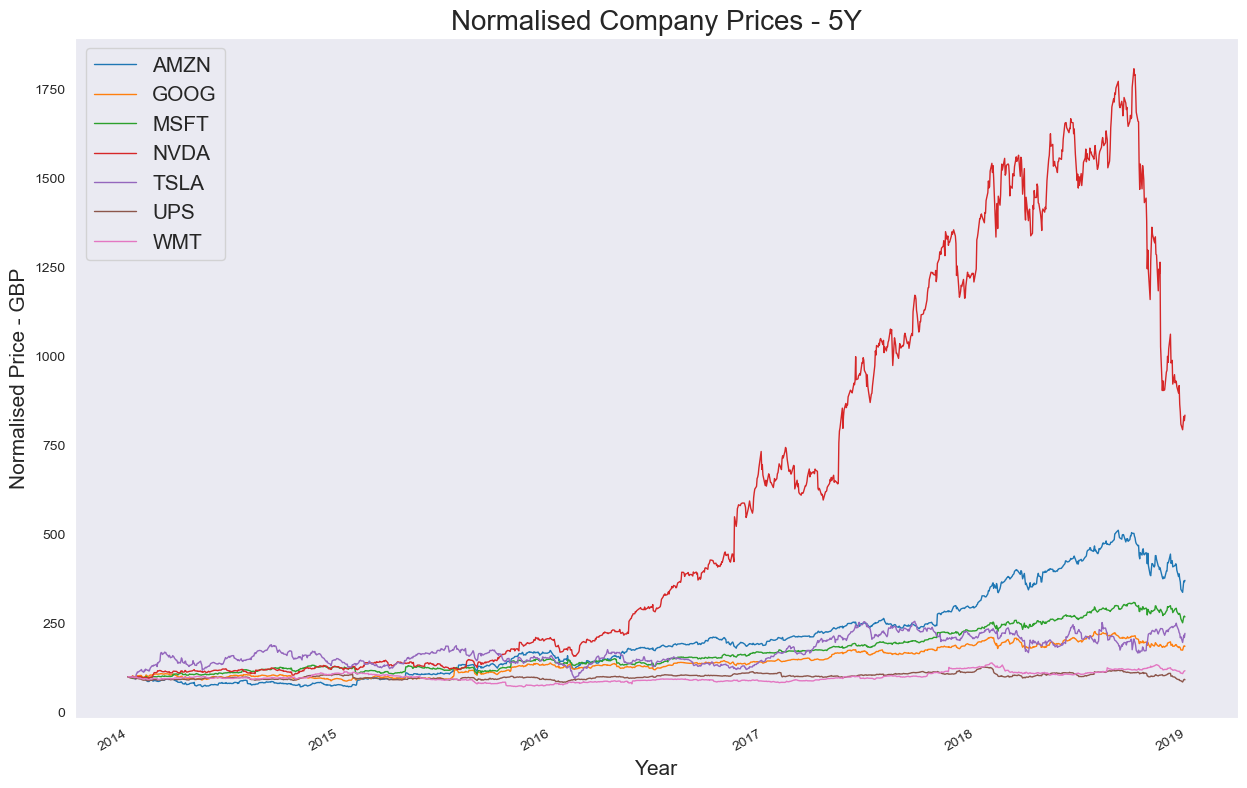

In [4]:
# Display the Price Movement of Stocks over 5 years
price_data.plot(figsize=(15,10), subplots=False, linewidth=1)
plt.title('Company Prices - 5Y', fontsize=20)
plt.legend(fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Price - GBP', fontsize=15)
plt.grid()
plt.show()

# Calculate and Display the Normalised Price Movement of Stocks over 5 years
norm_price_data = price_data.div(price_data.iloc[0]).mul(100)
norm_price_data.plot(figsize=(15,10), linewidth=1)
plt.title('Normalised Company Prices - 5Y', fontsize=20)
plt.legend(fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Normalised Price - GBP', fontsize=15)
plt.grid()
plt.show()

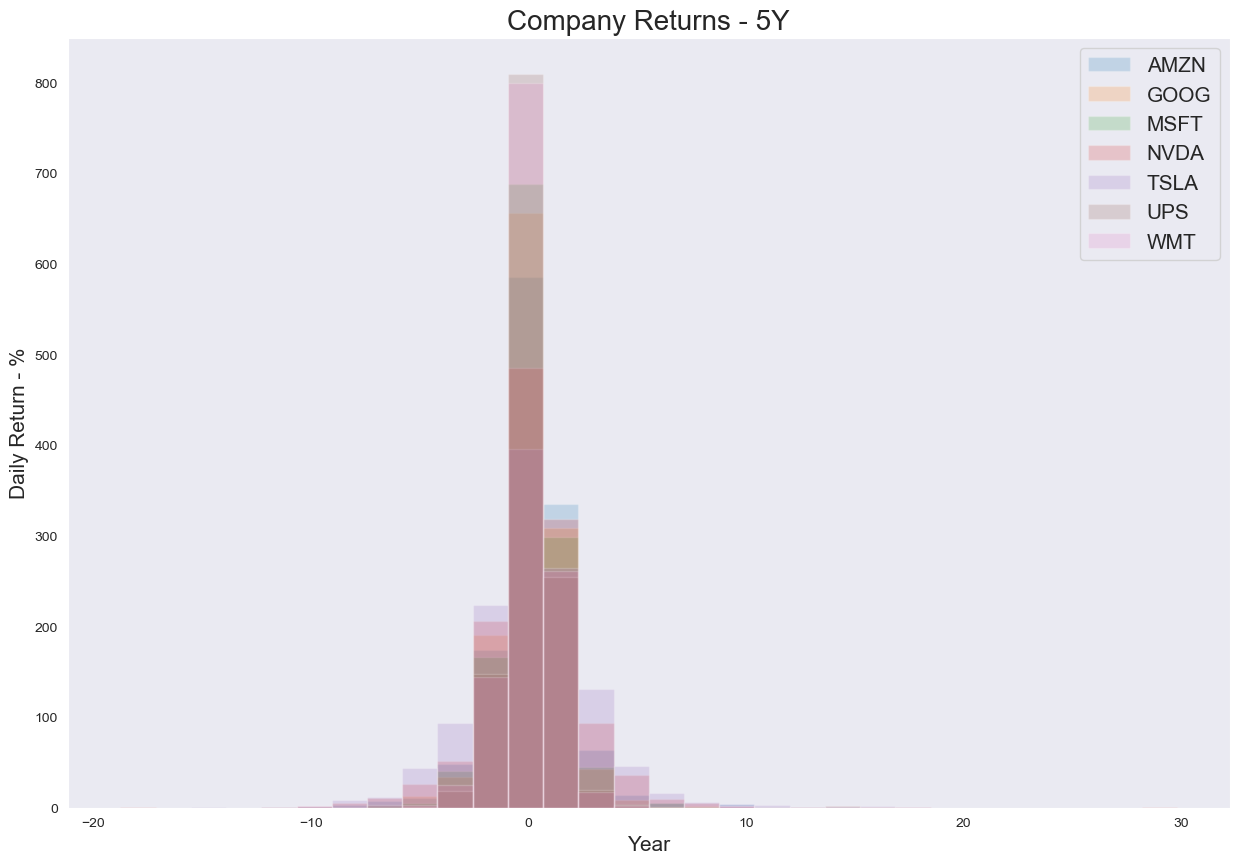

In [5]:
# Display Histogram of Returns for each Company
return_data = price_data.pct_change(periods=1).mul(100)
return_data.plot(kind='hist', bins=30, figsize=(15,10), subplots=False, alpha=0.2)
plt.title('Company Returns - 5Y', fontsize=20)
plt.legend(fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Daily Return - %', fontsize=15)
plt.grid()
plt.show()

In [6]:
# Correlation Analysis for Companies
corrs = return_data.corr()
corrs

,AMZN,GOOG,MSFT,NVDA,TSLA,UPS,WMT
AMZN,1.000000,0.621202,0.533113,0.360559,0.341436,0.332032,0.179791
GOOG,0.621202,1.000000,0.637359,0.402597,0.334002,0.389481,0.223659
MSFT,0.533113,0.637359,1.000000,0.434837,0.313478,0.444177,0.275363
NVDA,0.360559,0.402597,0.434837,1.000000,0.269478,0.291688,0.150683
TSLA,0.341436,0.334002,0.313478,0.269478,1.000000,0.225549,0.169663
UPS,0.332032,0.389481,0.444177,0.291688,0.225549,1.000000,0.325474
WMT,0.179791,0.223659,0.275363,0.150683,0.169663,0.325474,1.000000


Running Optimal Portfolio Builder...


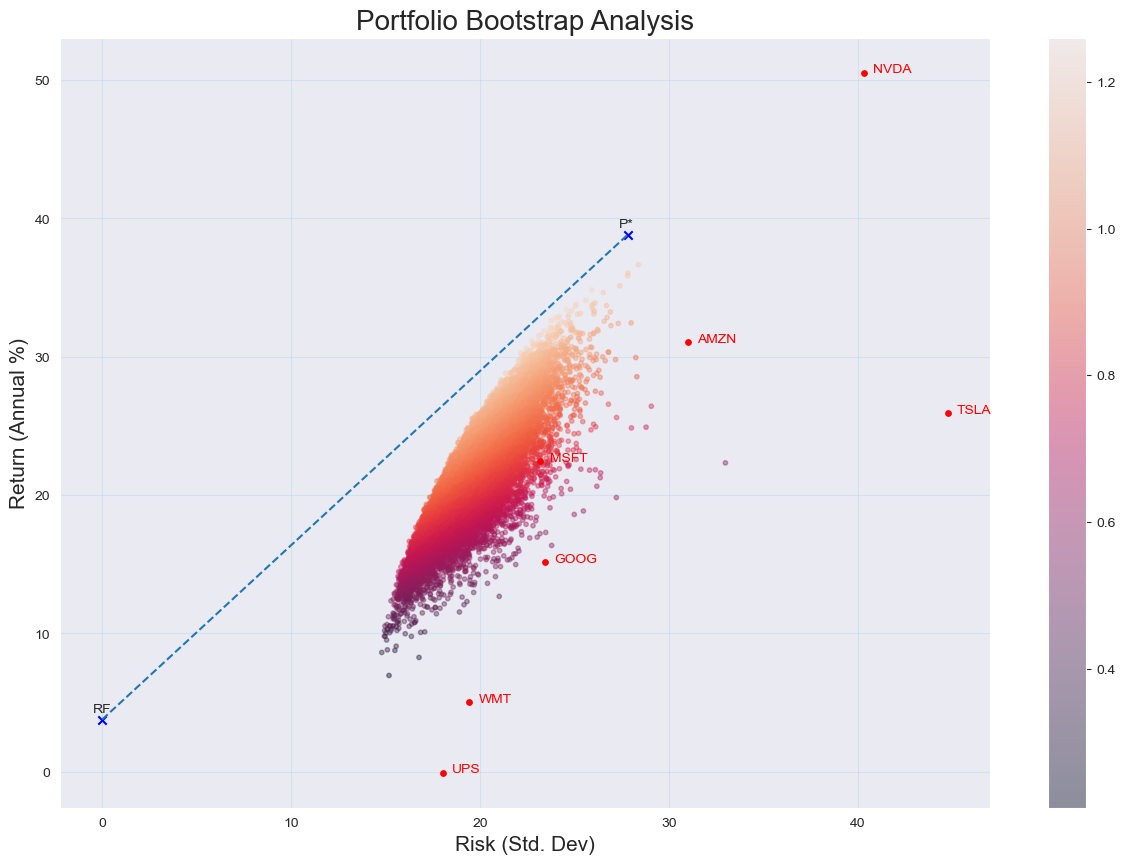

In [7]:
print('Running Optimal Portfolio Builder...')

# Find Expected Annual Return and Risk (Std. Dev) of Companies and Sharpe's
risk_free_return = 3.77
risk_return_data = annual_risk_return(return_data)
risk_return_data['Sharpe'] = (risk_return_data.Return - risk_free_return) / risk_return_data.Risk

# Find Risk/Return/Sharpe of Generated Portfolios
port_risk_return = annual_risk_return(return_data.dot(rand_port_weights.T))
port_risk_return['Sharpe'] = (port_risk_return.Return - risk_free_return) / port_risk_return.Risk

# Locate Max Sharpe Ratio
max_sharpe_index = port_risk_return.Sharpe.idxmax()
opt_weights = rand_port_weights[max_sharpe_index, :]
opt_stats = port_risk_return.iloc[max_sharpe_index]

# Display Portfolio Results against Companies
plt.figure(figsize=(15,10))
plt.grid(color='lightblue', alpha=0.4)
plt.xlabel('Risk (Std. Dev)', fontsize=15)
plt.ylabel('Return (Annual %)', fontsize=15)
plt.title('Portfolio Bootstrap Analysis', fontsize=20)
plt.scatter(port_risk_return.loc[:, 'Risk'], port_risk_return.loc[:, 'Return'], c=port_risk_return.loc[:, 'Sharpe'], s=10, alpha=0.4)
plt.colorbar()
plt.scatter(risk_return_data.loc[:, 'Risk'], risk_return_data.loc[:, 'Return'], color='r', s=15)
for i in risk_return_data.index:
    plt.annotate(i, xy=(risk_return_data.loc[i, 'Risk'] + 0.5, risk_return_data.loc[i, 'Return']), color='r')
# Risk Free Point:
plt.scatter(x=0, y=risk_free_return, marker='x', color='blue')
plt.annotate('RF', xy=(-0.5, risk_free_return+0.5))
# Max Sharpe Portfolio
plt.scatter(opt_stats.Risk, opt_stats.Return, marker='x', color='blue')
plt.annotate('P*', xy=(opt_stats.Risk - 0.5, opt_stats.Return + 0.5))
plt.plot([0, opt_stats.Risk], [risk_free_return, opt_stats.Return], linestyle='dashed')
plt.show()

# So Far...

### So far, the code allows the user to input as many ticker symbols as they wish.
- Note that if a ticker symbol is invalid, we do get issues down the line...

### The code then:
- Imports price for last 5 years for ticker symbols
- Generates the weights for the random portfolios that will be used in bootstrap anaylsis
- Display absolute stock prices over 5 years
- Display normalised stock prices over 5 years (better practice)
- Display histogram of stock returns (cluttered and messy...)

### Bootstrapping Process:
- Calculate expected annual risk return of stocks using the defined function
- Apply these risks and returns to the random weights
- Determine Sharpe for each random portfolio
- Locate portfolio with max. Sharpe and then the associated weights
- Display the random portfolios, highlighting optimal option

### Added Elements:
- CML Added (Capital Market line) reflecting combinations of optimal portfolio and risk free asset (bonds)